In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

In [2]:
data = pd.read_csv('output/hotel_review_data.csv')
len(data)

10000

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  int64  
 1   address             10000 non-null  object 
 2   city                10000 non-null  object 
 3   country             10000 non-null  object 
 4   latitude            10000 non-null  float64
 5   longitude           10000 non-null  float64
 6   name                10000 non-null  object 
 7   postalCode          10000 non-null  object 
 8   province            10000 non-null  object 
 9   reviews_rating      10000 non-null  int64  
 10  reviews_sourceURLs  10000 non-null  object 
 11  reviews_text        10000 non-null  object 
 12  reviews_title       10000 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1015.8+ KB


In [4]:
data["city"].value_counts()

San Diego        1189
San Francisco     808
New Orleans       798
Atlanta           762
Orlando           734
                 ... 
Hartsville          1
Inglewood           1
Maumee              1
Portsmouth          1
Irvine              1
Name: city, Length: 842, dtype: int64

In [5]:
data["city_and_state"] = data["city"] + ", " + data["province"]

In [6]:
data["city_and_state"].value_counts()

San Diego, CA        1189
San Francisco, CA     808
New Orleans, LA       798
Atlanta, GA           762
Orlando, FL           734
                     ... 
Markleysburg, PA        1
Florence, AL            1
Nacogdoches, TX         1
Opelika, AL             1
Rock Hill, SC           1
Name: city_and_state, Length: 893, dtype: int64

In [7]:
new_data = data.groupby("city_and_state").filter(lambda x:len(x)>10)
len(new_data)
new_data["city_and_state"].value_counts()

San Diego, CA        1189
San Francisco, CA     808
New Orleans, LA       798
Atlanta, GA           762
Orlando, FL           734
                     ... 
Arlington, WA          11
Tulsa, OK              11
Gatlinburg, TN         11
Harrisburg, PA         11
Kearney, NE            11
Name: city_and_state, Length: 64, dtype: int64

In [8]:
new_data.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY"
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY"
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY"
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY"
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA"


In [9]:
from utils import preprocess_text
new_data["reviews_text_tokens"] = new_data["reviews_text"].apply(lambda x:' ' .join(preprocess_text(x, min_word_length=4)))
new_data.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state,reviews_text_tokens
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY",lovely hotel attention detail impressive thick...
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY",recently stay hotel trip lexington friend grou...
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY",moremore
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY",hampton decorate color scheme give feel luxury...
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA",water cold water awful.. food good.. staff fri...


In [10]:
city_tokens = new_data.groupby('city_and_state')['reviews_text_tokens'].sum()

In [11]:
city_tokens

city_and_state
Anaheim, CA             recommend hotel somewhere good value locate wi...
Arlington, WA           hotel great spot visit outlet casino cabela's....
Atlanta, GA             stay motel weekend everything motel excellent ...
Atlantic City, NJ       really chelsea good great location good restau...
Bend, OR                back 3night stay oxford bend hotel breath away...
                                              ...                        
Sheboygan, WI           around care quickly room close request room cl...
South Lake Tahoe, CA    hotel excellent location beach pier extend lak...
Tampa, FL               stay location several time problem reservation...
Tulsa, OK               luxury hotel architecture modern extremely roo...
Wisconsin Dells, WI     read hotel create account tell experience year...
Name: reviews_text_tokens, Length: 64, dtype: object

In [12]:
explore_df = pd.DataFrame({"Total Number of Tokens": city_tokens.apply(lambda x: len(x)),
                        "Number of Unique Tokens": city_tokens.apply(lambda x: len(set(x)))})

explore_df["Lexical Diversity"] = explore_df['Number of Unique Tokens'] / explore_df['Total Number of Tokens']

explore_df

,Total Number of Tokens,Number of Unique Tokens,Lexical Diversity
city_and_state,,,
"Anaheim, CA",93931,44,0.000468
"Arlington, WA",2117,34,0.016060
"Atlanta, GA",296796,43,0.000145
"Atlantic City, NJ",23861,40,0.001676
"Bend, OR",2175,34,0.015632
...,...,...,...
"Sheboygan, WI",1832,26,0.014192
"South Lake Tahoe, CA",5106,30,0.005875
"Tampa, FL",5877,37,0.006296


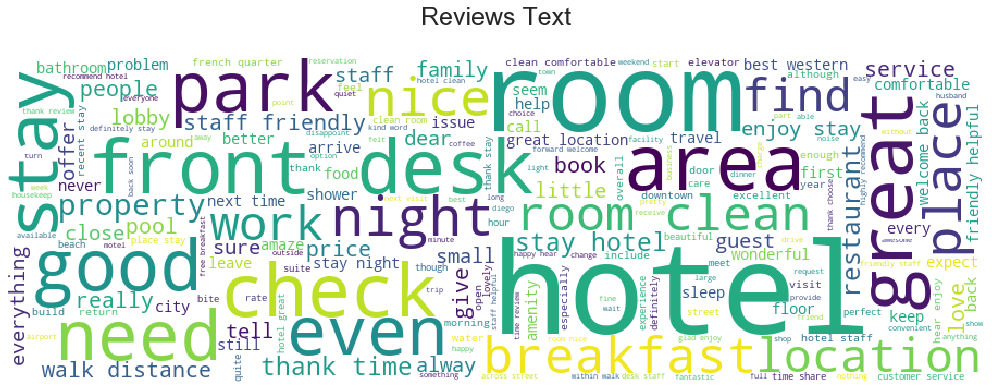

In [39]:
from wordcloud import WordCloud
rt = new_data['reviews_text_tokens']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('Reviews Text\n',size=25)
plt.axis('off')
plt.show()